This notebook is for demonstrating how to use a trained PM2.5 prediction model to make predictions on a target area.
There is also a script version for just generating predictoins in `scripts/predict.py`. Both utilize the same underlying prediction logic.

The input is a CSV/Dataframe of locations, represented by coordinates. In our sample notebook, our goal is to predict daily PM2.5 levels for the Mueang Chiang Mai admin level 2 district for the year 2021.

To visualize the input:

![Mueang Chiang Mai Tile Centroids](img/chiangmai_centroids.png)

(*This was generated with QGIS and exported to a CSV file*)



# Imports

In [2]:
%load_ext autoreload 
%autoreload 2

import geopandas as gpd
import re

import branca
import folium
import joblib
import numpy as np
import pandas as pd
from shapely import wkt

import sys
sys.path.append("../../")

from src.config import settings
from src.data_processing import feature_collection_pipeline, geom_utils
from src.prediction import predict_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [3]:
DEBUG = True

# CSV file for target roll-out location
CENTROIDS_PATH = "data/mueang_chiang_mai_tile_centroids.csv"

# Where to save the model predictions of  daily PM2.5 levels
OUTPUT_PREDICTIONS_FILE = "data/chiangmai_2021_predictions.csv" if not DEBUG else "data/debug.csv"

# Desired date range
START_DATE = "2021-01-01"
END_DATE = "2021-12-31"

# ID Column in the target CSV file
ID_COL = "id"

# What to name the column for predictions
PRED_COL = "predicted_pm2.5"

# Model being used was trained using 1km x 1km bounding box
BBOX_SIZE_KM = 1

# Path to the model to be used for prediction
MODEL_PATH = settings.DATA_DIR / "latest_model.pkl"

# Path to the population raster (In our study, we're using the Thai 2020 HRSL raster)
HRSL_TIF = settings.DATA_DIR / "tha_general_2020.tif"



# Load Area of Interest

In [4]:
def extract_lon_lat(wkt_string_point):
    regex = r'[0-9-\.]+'
    parsed_geom = re.findall(regex, wkt_string_point)
    parsed_geom = [float(i) for i in parsed_geom]
    assert len(parsed_geom) == 2
    return parsed_geom[0], parsed_geom[1]


def load_centroids(centroids_path):
    locations_gdf = gpd.read_file(centroids_path)
    all_lon_lat = locations_gdf["WKT"].apply(lambda x: extract_lon_lat(x)).tolist()
    all_lon, all_lat = zip(*all_lon_lat)

    locations_gdf["longitude"] = all_lon
    locations_gdf["latitude"] = all_lat 

    locations_df = pd.DataFrame(locations_gdf)
    locations_df.drop(["geometry", "WKT"], axis=1, inplace=True)

    return locations_df
    

In [7]:
locations_df = load_centroids(CENTROIDS_PATH)

if DEBUG:
    locations_df = locations_df[:2]

len(locations_df)

2

In [8]:
locations_df.columns

Index(['id', 'left', 'top', 'right', 'bottom', 'Shape_Leng', 'Shape_Area',
       'ADM3_EN', 'ADM3_TH', 'ADM3_PCODE', 'ADM3_REF', 'ADM3ALT1EN',
       'ADM3ALT2EN', 'ADM3ALT1TH', 'ADM3ALT2TH', 'ADM2_EN', 'ADM2_TH',
       'ADM2_PCODE', 'ADM1_EN', 'ADM1_TH', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_TH',
       'ADM0_PCODE', 'date', 'validOn', 'validTo', 'longitude', 'latitude'],
      dtype='object')

# Predict

In [9]:
results_df = predict_utils.predict(
        locations_df,
        start_date=START_DATE,
        end_date=END_DATE,
        id_col=ID_COL,
        hrsl_tif=HRSL_TIF,
        model_path=MODEL_PATH,
        bbox_size_km=BBOX_SIZE_KM,
        pred_col=PRED_COL,
    )

2022-05-19 02:44:58.818 | INFO     | src.prediction.predict_utils:predict:20 - Running prediction on 2 locations from 2021-01-01 to 2021-12-31...
2022-05-19 02:44:58.820 | INFO     | src.prediction.predict_utils:predict:24 - Collecting features...
2022-05-19 02:44:58.838 | INFO     | src.data_processing.feature_collection_pipeline:collect_features_for_locations:86 - Authenticating with GEE...
2022-05-19 02:45:04.804 | INFO     | src.data_processing.feature_collection_pipeline:collect_features_for_locations:90 - Computing population sums...
2022-05-19 02:45:04.867 | INFO     | src.data_processing.feature_collection_pipeline:collect_features_for_locations:96 - Collecting GEE datasets...
2022-05-19 02:45:04.869 | INFO     | src.data_processing.feature_collection_pipeline:collect_gee_datasets:152 - Collecting GEE data (1 / 4): {'collection_id': 'COPERNICUS/S5P/OFFL/L3_AER_AI', 'bands': ['absorbing_aerosol_index'], 'preprocessors': [<function aggregate_daily_s5p_aerosol at 0x7f278e3b0f80>]}

{'collection_id': 'COPERNICUS/S5P/OFFL/L3_AER_AI', 'bands': ['absorbing_aerosol_index'], 'preprocessors': [<function aggregate_daily_s5p_aerosol at 0x7f278e3b0f80>]}


  0%|          | 0/2 [00:00<?, ?it/s]

2022-05-19 02:45:17.560 | INFO     | src.data_processing.feature_collection_pipeline:collect_gee_datasets:152 - Collecting GEE data (2 / 4): {'collection_id': 'ECMWF/CAMS/NRT', 'bands': ['total_aerosol_optical_depth_at_550nm_surface'], 'preprocessors': [<function rescale_cams_aod at 0x7f278e3b0e60>, <function aggregate_daily_cams_aod at 0x7f278e3b0ef0>]}


{'collection_id': 'ECMWF/CAMS/NRT', 'bands': ['total_aerosol_optical_depth_at_550nm_surface'], 'preprocessors': [<function rescale_cams_aod at 0x7f278e3b0e60>, <function aggregate_daily_cams_aod at 0x7f278e3b0ef0>]}


  0%|          | 0/2 [00:00<?, ?it/s]

2022-05-19 02:45:36.280 | INFO     | src.data_processing.feature_collection_pipeline:collect_gee_datasets:152 - Collecting GEE data (3 / 4): {'collection_id': 'MODIS/006/MOD13A2', 'bands': ['NDVI', 'EVI'], 'preprocessors': [<function aggregate_daily_ndvi at 0x7f278e3bd5f0>]}


{'collection_id': 'MODIS/006/MOD13A2', 'bands': ['NDVI', 'EVI'], 'preprocessors': [<function aggregate_daily_ndvi at 0x7f278e3bd5f0>]}


  0%|          | 0/2 [00:00<?, ?it/s]

2022-05-19 02:45:48.425 | INFO     | src.data_processing.feature_collection_pipeline:collect_gee_datasets:152 - Collecting GEE data (4 / 4): {'collection_id': 'ECMWF/ERA5_LAND/HOURLY', 'bands': ['dewpoint_temperature_2m', 'temperature_2m', 'total_precipitation_hourly', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'surface_pressure'], 'preprocessors': [<function aggregate_daily_era5 at 0x7f278e3b0dd0>]}


{'collection_id': 'ECMWF/ERA5_LAND/HOURLY', 'bands': ['dewpoint_temperature_2m', 'temperature_2m', 'total_precipitation_hourly', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'surface_pressure'], 'preprocessors': [<function aggregate_daily_era5 at 0x7f278e3b0dd0>]}


  0%|          | 0/2 [00:00<?, ?it/s]

2022-05-19 02:46:05.397 | INFO     | src.prediction.predict_utils:predict:41 - Running the model...


In [10]:
results_df.to_csv(OUTPUT_PREDICTIONS_FILE, index=False)

# EDA on Predictions

## Utility Functions

In [11]:
def load_results(results_path, pred_col=PRED_COL):
    df = pd.read_csv(results_path)
    # Post-processing: clip negative values to 0
    df[pred_col] = df[pred_col].apply(lambda x: x if x > 0 else 0)
    return df

In [12]:
def aggregate_preds(results_path, start_date=None, end_date=None, id_col=ID_COL, pred_col=PRED_COL):
    # Initialize DF
    df = load_results(results_path)
    if start_date and end_date:
        # Filter according to dates
        date_mask =(df['date'] >= start_date) & (df['date'] <= end_date)
        df = df[date_mask]
        
    # Initialize GDF
    df = geom_utils.generate_bboxes(df, bbox_size_km=BBOX_SIZE_KM, geometry_col="geometry")
    gdf = gpd.GeoDataFrame(df, geometry=df["geometry"].apply(lambda x: wkt.loads(x)))
    
    # Get the average predicted value per tile
    gdf = gdf.dissolve(by=[ID_COL], aggfunc='mean')
    
    return gdf
    

In [13]:
def categorize_value(value):
    if value >= 250.5:
        return "hazardous"
    if value >= 150.5:
        return "very_unhealthy"
    if value >= 55.5:
        return "unhealthy"
    if value >= 35.5:
        return "unhealthy_for_sensitive_groups"
    if value >= 12.1:
        return "moderate"
    return "good"

def generate_pm25_cmap(min=0, max=500.0):
    lower_bounds = [0.0, 12.1, 35.5, 55.5, 150.5, 250.5]
    colors = ["green", "yellow", "orange", "red", "purple", "brown"]
    step = branca.colormap.StepColormap(colors,
                       vmin=min, vmax=max, index=lower_bounds,
                       caption='Predicted PM2.5 Levels')
    return step


In [14]:
def viz_preds(gdf, tooltip=True, pred_col=PRED_COL):    
    gdf_centroid = gdf.dissolve().geometry.centroid.values[0]
    
    # Categorize for the tooltip
    gdf["category"] = gdf[pred_col].apply(lambda x: categorize_value(x))
    
    m = folium.Map(location=[gdf_centroid.y, gdf_centroid.x], width=800, height=800, zoom_start=12)
    style_kwds = {
        "opacity": 0.3
    }
    
    gdf.explore(pred_col, m=m, style_kwds=style_kwds, tooltip=tooltip, cmap=generate_pm25_cmap())
    return m
    

## Results File to perform EDA on

In [15]:
results_path = "data/predictions_chiangmai_2021.csv"

## Annual PM2.5 Mean

In [16]:
df = load_results(results_path)
df[PRED_COL].mean()

33.14694928831249

## PM2.5 Levels per Month

In [17]:
df = load_results(results_path)
df["month"] = pd.to_datetime(df["date"]).dt.month
df["year"] = pd.to_datetime(df["date"]).dt.year
summary = df[["month", "year", PRED_COL]].groupby(["month", "year"]).describe()
summary.columns = summary.columns.droplevel()

summary

,,count,mean,std,min,25%,50%,75%,max
month,year,,,,,,,,
1,2021,6386.0,63.341345,19.154061,9.560035,49.839914,64.013845,75.491304,128.008870
2,2021,5768.0,62.712000,20.386008,0.000000,50.420704,62.218142,75.830187,154.845050
3,2021,6386.0,89.400631,29.061196,12.208568,70.603714,82.384683,106.431964,194.495180
4,2021,6180.0,39.368582,23.987580,0.000000,23.908068,33.161674,46.084322,125.215570
5,2021,6386.0,20.232414,7.557263,0.000000,14.861941,20.420446,25.167452,47.917957
6,2021,6180.0,12.384718,5.910474,0.000000,8.034402,11.689604,15.377459,41.782063
7,2021,6386.0,9.755273,3.372766,0.000000,7.362451,9.453353,11.803314,21.478884
8,2021,6386.0,11.460670,4.219821,0.000000,8.422496,10.834995,13.911296,29.069271
9,2021,6180.0,12.319562,4.575653,0.000000,8.674928,12.057009,15.487342,30.527950


<AxesSubplot:xlabel='month'>

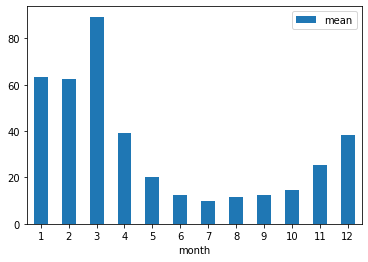

In [18]:
summary.reset_index().plot.bar(x="month", y="mean", rot=0)

Agricultural burning season in Thailand varies from place to place, but is generally in the earlier parts of the year.

This [article by iqair](https://www.iqair.com/blog/air-quality/thailand-2021-burning-season) conducted an analysis and considered Jan-March as the general burning season. Our model's predictions for Chiang Mai seem to conform to this.

Furthermore, the trend seems to be consistent with the monthly mean PM2.5 levels reported by IQAir where the start of the year sees the highest levels of PM2.5, which lowers starting May, then increases again towards the end of the year.

![Image taken from: https://www.iqair.com/blog/air-quality/thailand-2021-burning-season](img/chiangmai_monthly_averages_iqair.png)

## Visualize Certain Months

In [19]:
# Infer the columns used by the model for simplicity in the viz
model = joblib.load(MODEL_PATH)
keep_cols =  [ID_COL, PRED_COL] + model.feature_names  # This was saved from the train script

In [20]:
# March
gdf = aggregate_preds(results_path, 
                      start_date="2021-03-01", 
                      end_date="2021-03-31")
viz_preds(gdf, tooltip=keep_cols)

In [21]:
# June
gdf = aggregate_preds(results_path, 
                      start_date="2021-06-01", 
                      end_date="2021-06-30")
viz_preds(gdf, tooltip=keep_cols)

In [22]:
# December
gdf = aggregate_preds(results_path, 
                      start_date="2021-12-01", 
                      end_date="2021-12-31")
viz_preds(gdf, tooltip=keep_cols)